# 🍇 Lightweight Fruit Classification with MobileNetV2

<img src="https://www.diagnosisdiet.com/assets/images/7/fruit-og-jcnp4h14m2mh5t9.jpg">

## 🎯 Project Objective

The objective of this project is to build an efficient and accurate
fruit recognition system using deep learning.

A transfer learning approach is applied using the MobileNetV2
architecture to classify multiple fruit categories based on images.
The goal is to achieve high classification accuracy while maintaining
a lightweight and fast model suitable for practical applications.


In [3]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 🔎 Exploratory Data Analysis 

Before training the model, an exploratory data analysis was conducted
to better understand the dataset characteristics.

The dataset consists of multiple fruit classes, where each class is
stored in a separate folder. The following aspects were analyzed:

- Class distribution to detect potential imbalance
- Sample images to visually inspect image quality and variety
- Image size distribution to justify resizing strategies

EDA helped ensure that the dataset was suitable for training a deep
learning model and guided preprocessing decisions.


In [4]:
data_dir = "/kaggle/input/fruit-recognition"

In [5]:
classes = sorted([d for d in os.listdir(data_dir)
                  if os.path.isdir(os.path.join(data_dir, d))])

In [6]:
image_paths = []
for ext in ("jpg","jpeg","png","JPG","JPEG","PNG"):
    image_paths.extend(glob(os.path.join(data_dir, "*", f"*.{ext}")))

In [7]:
df = pd.DataFrame({"image_path": image_paths})

In [8]:
df["label"] = df["image_path"].apply(lambda p: os.path.basename(os.path.dirname(p)))

In [9]:
print("Sınıf sayısı:", df["label"].nunique())

Sınıf sayısı: 12


In [10]:
df.head()

,image_path,label
0,/kaggle/input/fruit-recognition/Orange/Orange0...,Orange
1,/kaggle/input/fruit-recognition/Orange/Orange0...,Orange
2,/kaggle/input/fruit-recognition/Orange/Orange0...,Orange
3,/kaggle/input/fruit-recognition/Orange/Orange0...,Orange
4,/kaggle/input/fruit-recognition/Orange/Orange0...,Orange


In [11]:
df.tail()

,image_path,label
31196,/kaggle/input/fruit-recognition/Mango/Mango002...,Mango
31197,/kaggle/input/fruit-recognition/Mango/Mango001...,Mango
31198,/kaggle/input/fruit-recognition/Mango/Mango003...,Mango
31199,/kaggle/input/fruit-recognition/Mango/Mango002...,Mango
31200,/kaggle/input/fruit-recognition/Mango/Mango002...,Mango


In [12]:
df.shape

(31201, 2)

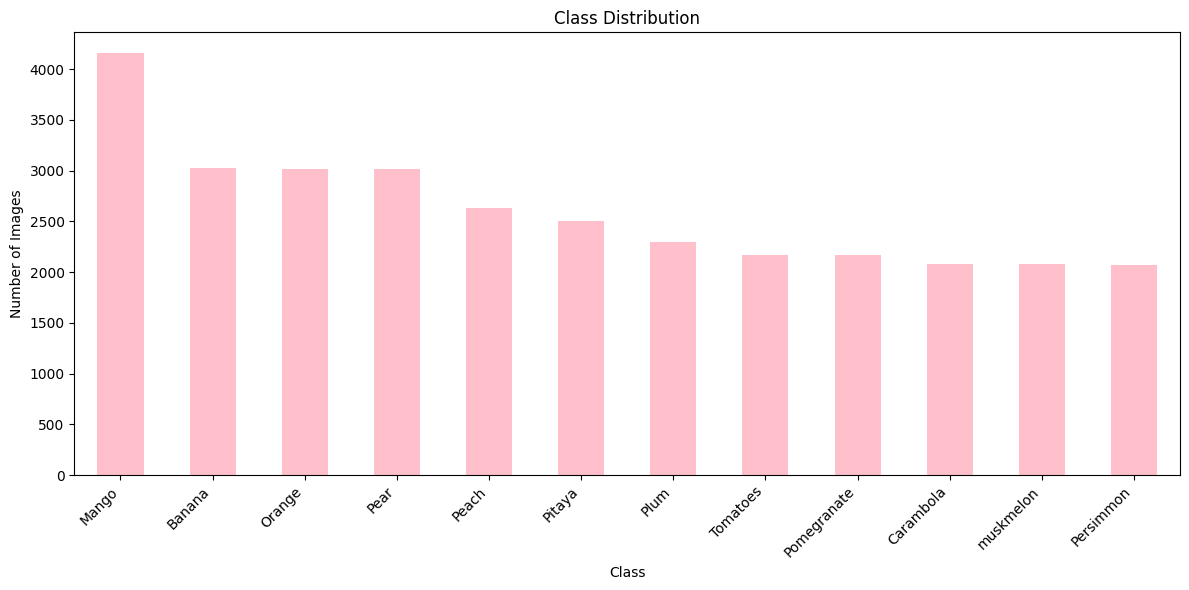

In [48]:
label_counts = df["label"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
label_counts.plot(kind="bar", color="pink")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

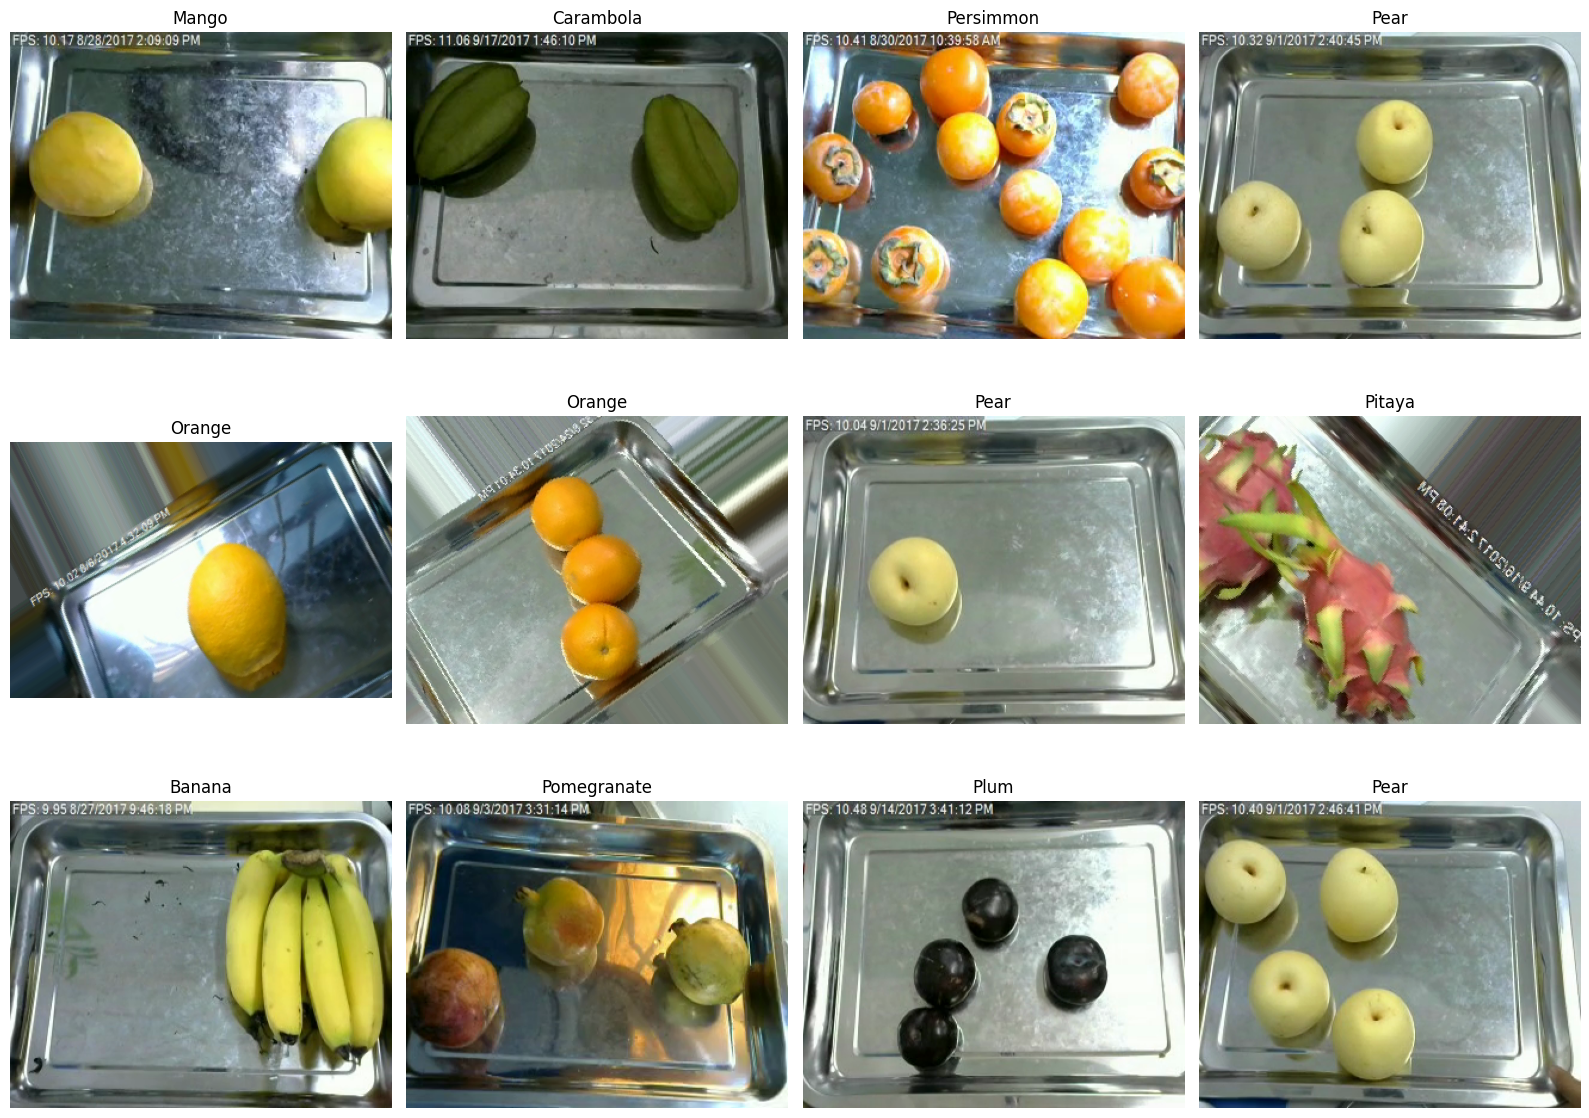

In [35]:
def show_samples(df, n=12, seed=42):
    sample_df = df.sample(n=min(n, len(df)), random_state=seed).reset_index(drop=True)
    cols = 4
    rows = int(np.ceil(len(sample_df) / cols))
    
    plt.figure(figsize=(cols * 4, rows * 4))
    for i, row in sample_df.iterrows():
        img = Image.open(row["image_path"]).convert("RGB")
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(row["label"])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(df, n=12)

In [36]:
def get_image_size(path):
    with Image.open(path) as img:
        return img.size 

sizes = df["image_path"].sample(min(800, len(df)), random_state=42).apply(get_image_size)
sizes_df = pd.DataFrame(sizes.tolist(), columns=["width", "height"])

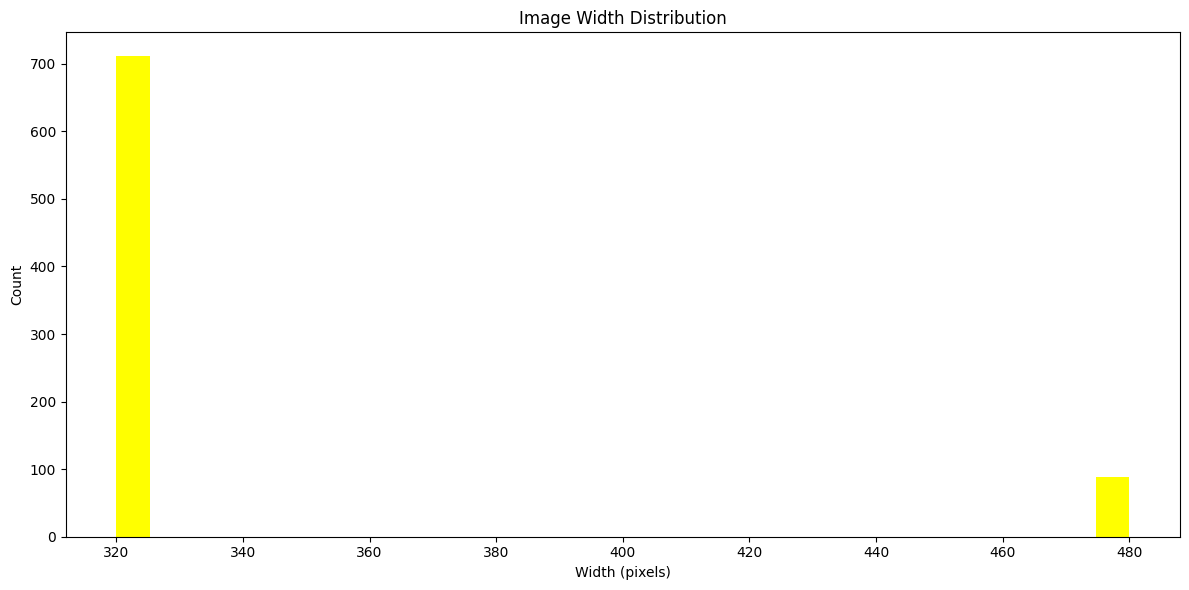

In [47]:
plt.figure(figsize=(12, 6))
plt.hist(sizes_df["width"], bins=30, color="yellow")
plt.title("Image Width Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

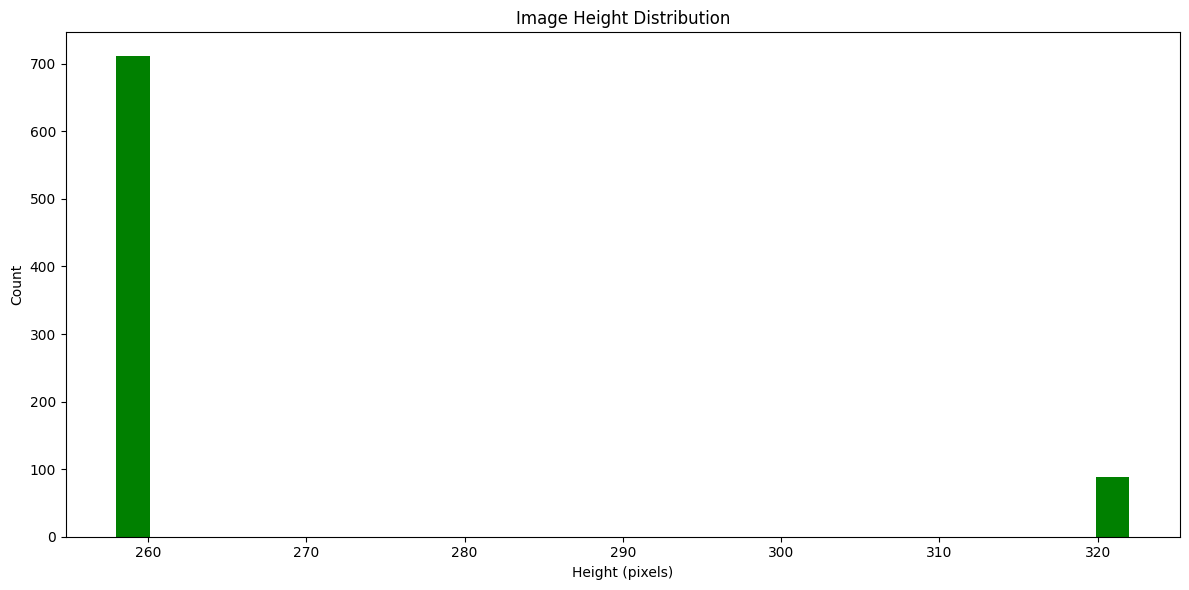

In [46]:
plt.figure(figsize=(12, 6))
plt.hist(sizes_df["height"], bins=30, color="green")
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

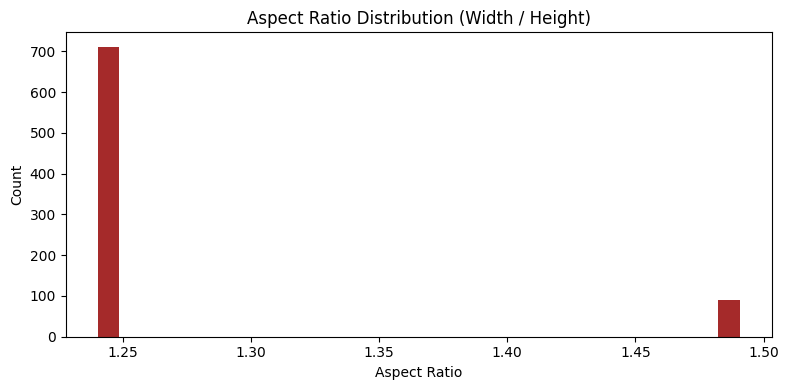

In [45]:
sizes_df["aspect_ratio"] = sizes_df["width"] / sizes_df["height"]

plt.figure(figsize=(8, 4))
plt.hist(sizes_df["aspect_ratio"], bins=30, color="brown")
plt.title("Aspect Ratio Distribution (Width / Height)")
plt.xlabel("Aspect Ratio")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## 🧼 Data Preprocessing

Several preprocessing steps were applied to prepare the images
for model training:

- Images were resized to a fixed resolution of 128 × 128 pixels
- Pixel values were normalized to the [0, 1] range
- Labels were automatically extracted from folder names
- Data augmentation techniques were applied to improve generalization

Data augmentation included random horizontal flips, rotations,
and zoom operations to reduce overfitting and enhance robustness.


In [17]:
le = LabelEncoder()

In [18]:
df["label_id"] = le.fit_transform(df["label"])

In [19]:
train_df, val_df = train_test_split(df,test_size=0.2,random_state=SEED,stratify=df["label_id"])

In [20]:
num_classes = df["label_id"].nunique()

In [49]:
IMG_SIZE = (128, 128)   
BATCH = 32

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32) 
    img = tf.image.resize(img, IMG_SIZE)
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["image_path"].values, train_df["label_id"].values)).map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df["image_path"].values, val_df["label_id"].values)).map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(2000, seed=SEED).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

## 🤖 Model Training

The model was built using MobileNetV2 as a backbone with pre-trained
ImageNet weights. The top layers were replaced with custom layers
to adapt the model for multiclass fruit classification.

Key training details:
- Optimizer: Adam
- Loss function: Sparse Categorical Crossentropy
- Evaluation metric: Accuracy
- Early stopping and learning rate reduction were used

The model was trained in two phases:
1. Feature extraction with frozen base layers
2. Fine-tuning with partial unfreezing of MobileNetV2 layers


In [22]:
data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),])

In [23]:
base = keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet")
base.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_aug(inputs)                       
x = keras.applications.mobilenet_v2.preprocess_input(x * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

In [25]:
model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

In [26]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │        15,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,273,356 (8.67 MB)

 Trainable params: 15,372 (60.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [27]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5),]

In [28]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks)

Epoch 1/20


I0000 00:00:1770080760.049616     237 cuda_dnn.cc:529] Loaded cuDNN version 91002


780/780 ━━━━━━━━━━━━━━━━━━━━ 119s 133ms/step - accuracy: 0.8203 - loss: 0.5940 - val_accuracy: 0.9822 - val_loss: 0.0702 - learning_rate: 0.0010
Epoch 2/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - accuracy: 0.9776 - loss: 0.0706 - val_accuracy: 0.9878 - val_loss: 0.0469 - learning_rate: 0.0010
Epoch 3/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - accuracy: 0.9841 - loss: 0.0491 - val_accuracy: 0.9912 - val_loss: 0.0333 - learning_rate: 0.0010
Epoch 4/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - accuracy: 0.9890 - loss: 0.0366 - val_accuracy: 0.9926 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 5/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - accuracy: 0.9859 - loss: 0.0397 - val_accuracy: 0.9912 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 6/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 52s 62ms/step - accuracy: 0.9879 - loss: 0.0346 - val_accuracy: 0.9921 - val_loss: 0.0261 - learning_rate: 0.0010
Epoch 7/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 53s 64ms/step - accuracy: 0.9887 - loss: 0.03

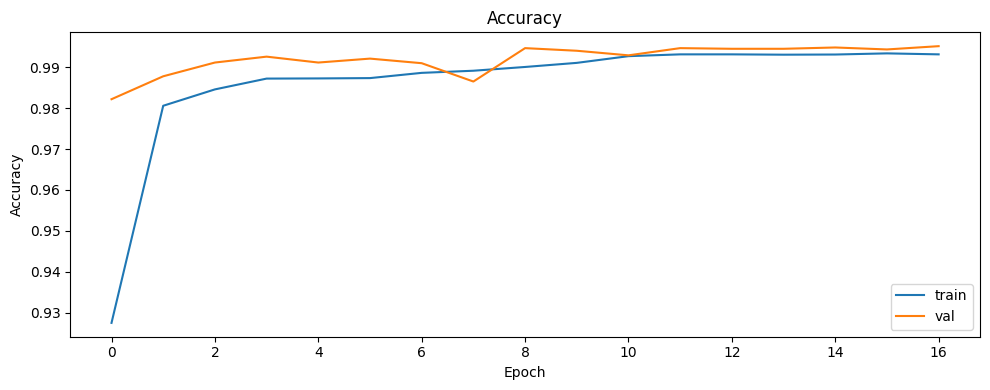

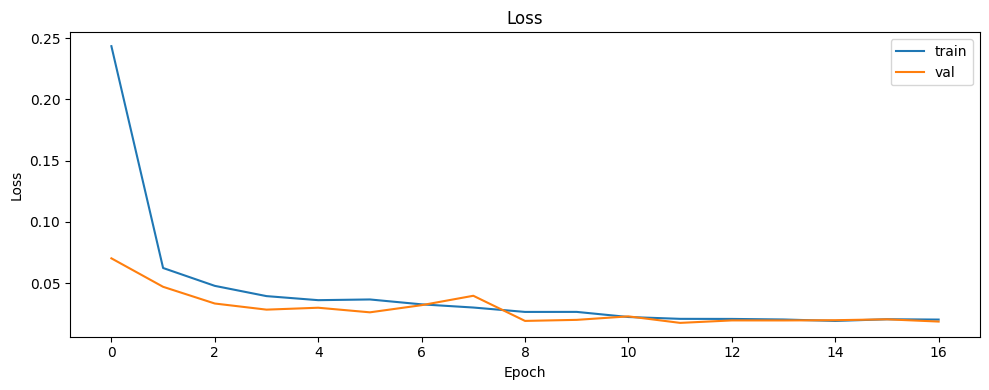

In [29]:
plt.figure(figsize=(10,4))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.tight_layout()
plt.show()

In [30]:
base.trainable = True
for layer in base.layers[:-30]:
    layer.trainable = False

In [31]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

In [32]:
ft_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks)

Epoch 1/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 67s 69ms/step - accuracy: 0.9601 - loss: 0.1398 - val_accuracy: 0.9912 - val_loss: 0.0280 - learning_rate: 1.0000e-04
Epoch 2/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 55s 67ms/step - accuracy: 0.9895 - loss: 0.0322 - val_accuracy: 0.9883 - val_loss: 0.0421 - learning_rate: 1.0000e-04
Epoch 3/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 55s 67ms/step - accuracy: 0.9936 - loss: 0.0203 - val_accuracy: 0.9888 - val_loss: 0.0407 - learning_rate: 1.0000e-04
Epoch 4/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 55s 67ms/step - accuracy: 0.9948 - loss: 0.0134 - val_accuracy: 0.9970 - val_loss: 0.0124 - learning_rate: 5.0000e-05
Epoch 5/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 55s 66ms/step - accuracy: 0.9963 - loss: 0.0105 - val_accuracy: 0.9971 - val_loss: 0.0108 - learning_rate: 5.0000e-05
Epoch 6/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 56s 68ms/step - accuracy: 0.9967 - loss: 0.0099 - val_accuracy: 0.9979 - val_loss: 0.0078 - learning_rate: 5.0000e-05
Epoch 7/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 55s 67ms/ste

## 📊 Results

The model achieved excellent performance on both training and
validation datasets.

### Training Performance
- Final training accuracy reached approximately **99.8%**
- Training loss steadily decreased, indicating stable convergence

### Validation Performance
- Validation accuracy remained consistently high at around **99.8%**
- Validation loss followed a similar downward trend to training loss
- No significant gap between training and validation curves was observed

This indicates that the model learned meaningful features without
overfitting and generalized well to unseen data.

Overall, the results demonstrate that MobileNetV2 combined with
transfer learning is highly effective for fruit recognition tasks.


In [41]:
model.save("fruit_recognition_model.h5")

In [56]:
import json

label_map = {int(i): name for i, name in enumerate(le.classes_)} 
with open("labels.json", "w") as f:
    json.dump(label_map, f, indent=2)

label_map

{0: 'Banana',
 1: 'Carambola',
 2: 'Mango',
 3: 'Orange',
 4: 'Peach',
 5: 'Pear',
 6: 'Persimmon',
 7: 'Pitaya',
 8: 'Plum',
 9: 'Pomegranate',
 10: 'Tomatoes',
 11: 'muskmelon'}